# Phoneme Embeddings

In [1]:
pip install phonemizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.8/103.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.4/213.4 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.1/565.1 kB 23.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# Morphology Embeddings

In [2]:
pip install morfessor


Note: you may need to restart the kernel to use updated packages.


# Environment set

In [3]:
!pip install phonemizer morfessor
!apt-get install espeak-ng





The following additional packages will be installed:
  espeak-ng-data libespeak-ng1 libpcaudio0 libsonic0
The following NEW packages will be installed:
  espeak-ng espeak-ng-data libespeak-ng1 libpcaudio0 libsonic0
0 upgraded, 5 newly installed, 0 to remove and 122 not upgraded.
Need to get 4,526 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libpcaudio0 amd64 1.1-6build2 [8,956 B]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libsonic0 amd64 0.2.0-11build1 [10.3 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 espeak-ng-data amd64 1.50+dfsg-10ubuntu0.1 [3,956 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libespeak-ng1 amd64 1.50+dfsg-10ubuntu0.1 [207 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 espeak-ng amd64 1.50+dfsg-10ubuntu0.1 [343 kB]
Fetched 4,526 kB in 1s (4,422 kB/s)
Selecting previously unselected packa

# Combined Embedding Layer

In [4]:
import torch
import torch.nn as nn
from transformers import BertModel

# Example values (replace with actual numbers from your dataset)
num_phonemes = 100  # Adjust based on how many unique phonemes you have
num_morphs = 100    # Adjust based on your morph units
num_labels = 3      # E.g., 3 classes: Standard Malay, Sabah dialect, Code-switch

class CustomBertWithPhonemeMorph(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-multilingual-cased")
        self.phoneme_emb = nn.Embedding(num_phonemes, 768)
        self.morph_emb = nn.Embedding(num_morphs, 768)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, num_labels)

    def forward(self, input_ids, phoneme_ids, morph_ids, attention_mask=None):
        # [batch_size, seq_len, emb_dim]
        phoneme_vec = self.phoneme_emb(phoneme_ids).mean(dim=2)  # Mean pooling over morph units
        morph_vec = self.morph_emb(morph_ids).mean(dim=2)

        # BERT output
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        cls_emb = outputs.last_hidden_state[:, 0, :]  # [CLS] token representation

        # Combine embeddings
        combined = cls_emb + phoneme_vec[:, 0, :] + morph_vec[:, 0, :]  # Keep batch-first
        logits = self.classifier(self.dropout(combined))
        return logits


2025-04-22 04:54:08.949365: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745297649.132231      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745297649.185645      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# -----TEST----------

# Step 1: Dummy Test Dataset

In [5]:
# Simulated text samples
texts = [
    "Saya pergi ke pasar",                          # Standard Malay
    "Aku mau pigi kedai bah",                       # Sabah dialect
    "Saya want to buy makanan from kedai"           # Code-switched Malay-English
]

# Fake labels for classification: 0 = Malay, 1 = Dialect, 2 = Code-Switch
labels = [0, 1, 2]


#  Step 2: Tokenizer

In [6]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

# Step 3: Fake Phoneme & Morph IDs

In [7]:
import torch

batch_size, seq_len = inputs['input_ids'].shape

# Randomly simulate phoneme and morph IDs (normally derived from actual phoneme/morph analyzers)
phoneme_ids = torch.randint(0, 100, (batch_size, seq_len, 5))  # 5 phoneme units per word
morph_ids = torch.randint(0, 100, (batch_size, seq_len, 3))    # 3 morphemes per word


# Step 4: Define Models

In [8]:
class BaselineModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-multilingual-cased")
        self.classifier = nn.Linear(768, 3)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        cls_emb = outputs.last_hidden_state[:, 0, :]
        return self.classifier(cls_emb)

baseline_model = BaselineModel()
custom_model = CustomBertWithPhonemeMorph()  # From earlier cell


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

# Step 5: Forward Pass & Comparison

In [9]:
# Forward pass with baseline
with torch.no_grad():
    baseline_logits = baseline_model(inputs['input_ids'], attention_mask=inputs['attention_mask'])

# Forward pass with phoneme+morph model
with torch.no_grad():
    advanced_logits = custom_model(
        input_ids=inputs['input_ids'],
        attention_mask=inputs['attention_mask'],
        phoneme_ids=phoneme_ids,
        morph_ids=morph_ids
    )


# Step 6: Output Predictions

In [10]:
import torch.nn.functional as F

baseline_preds = torch.argmax(F.softmax(baseline_logits, dim=1), dim=1)
advanced_preds = torch.argmax(F.softmax(advanced_logits, dim=1), dim=1)

print("Ground Truth:", labels)
print("Baseline Predictions:", baseline_preds.tolist())
print("Phoneme+Morph Predictions:", advanced_preds.tolist())


Ground Truth: [0, 1, 2]
Baseline Predictions: [0, 0, 0]
Phoneme+Morph Predictions: [1, 1, 1]


# Test 2

In [11]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer
from sklearn.metrics import classification_report
import numpy as np


In [12]:
num_phonemes = 50
num_morphs = 100
num_labels = 2  # Changed from 3 → now only Kelantanese and Code-switch


In [13]:
class CustomBertWithPhonemeMorph(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-multilingual-cased")
        self.phoneme_emb = nn.Embedding(num_phonemes, 768)
        self.morph_emb = nn.Embedding(num_morphs, 768)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, num_labels)  # ✅ changed to 2

    def forward(self, input_ids, phoneme_ids, morph_ids, attention_mask=None):
        phoneme_vec = self.phoneme_emb(phoneme_ids).mean(dim=2)
        morph_vec = self.morph_emb(morph_ids).mean(dim=2)
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        cls_emb = outputs.last_hidden_state[:, 0, :]
        combined = cls_emb + phoneme_vec[:, 0, :] + morph_vec[:, 0, :]
        logits = self.classifier(self.dropout(combined))
        return logits


In [14]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

texts = [
    "Kawe nok gi kedai jap",              # Kelantanese
    "Demo makan gapo pagi tadi?",
    "Ore tu dok gi kerja lagi",
    "Mu buat gapo situ?",
    "Bakpo demo lambat sangat?",
    "I tengah buat kerja rumah sekarang",      # Code-switch
    "You nak makan sini or tapau?",
    "Boss suruh I settle that document cepat",
    "Dia tengah belajar untuk test tomorrow",
    "You boleh start dulu, I datang later"
]

original_labels = [1, 1, 1, 1, 1, 2, 2, 2, 2, 2]

# ✅ Normalize labels: 1 → 0 (Kelantanese), 2 → 1 (Code-switch)
labels = [0 if l == 1 else 1 for l in original_labels]

# Tokenize input text
encodings = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
input_ids = encodings['input_ids']
attention_mask = encodings['attention_mask']
batch_size, seq_len = input_ids.shape

# Simulated phoneme and morph IDs
phoneme_ids = torch.randint(0, num_phonemes, (batch_size, seq_len, 5))
morph_ids = torch.randint(0, num_morphs, (batch_size, seq_len, 5))


In [15]:
model = CustomBertWithPhonemeMorph()
model.eval()

with torch.no_grad():
    logits = model(input_ids, phoneme_ids, morph_ids, attention_mask=attention_mask)
    predictions = torch.argmax(logits, dim=1)


In [16]:
print("Predictions:", predictions.tolist())
print("Ground Truth:", labels)

print("\nClassification Report:")
print(classification_report(labels, predictions.tolist(), target_names=["Kelantanese", "Code-switch"]))


Predictions: [0, 1, 1, 1, 0, 0, 0, 1, 0, 1]
Ground Truth: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

Classification Report:
              precision    recall  f1-score   support

 Kelantanese       0.40      0.40      0.40         5
 Code-switch       0.40      0.40      0.40         5

    accuracy                           0.40        10
   macro avg       0.40      0.40      0.40        10
weighted avg       0.40      0.40      0.40        10



In [17]:
class BaselineBertClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-multilingual-cased")
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, num_labels)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        cls_emb = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(self.dropout(cls_emb))
        return logits

# Run baseline
baseline_model = BaselineBertClassifier()
baseline_model.eval()

with torch.no_grad():
    baseline_logits = baseline_model(input_ids, attention_mask=attention_mask)
    baseline_preds = torch.argmax(baseline_logits, dim=1)

print("\nBaseline Predictions:", baseline_preds.tolist())
print(classification_report(labels, baseline_preds.tolist(), target_names=["Kelantanese", "Code-switch"]))



Baseline Predictions: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
              precision    recall  f1-score   support

 Kelantanese       0.56      1.00      0.71         5
 Code-switch       1.00      0.20      0.33         5

    accuracy                           0.60        10
   macro avg       0.78      0.60      0.52        10
weighted avg       0.78      0.60      0.52        10



# TEST 3

In [18]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer
from torch.utils.data import Dataset

# 1. Define texts and labels
texts = [
    "Kawe nok gi kedai jap",  # Kelantanese
    "Demo makan gapo pagi tadi?",
    "Ore tu dok gi kerja lagi",
    "Mu buat gapo situ?",
    "Bakpo demo lambat sangat?",
    "I tengah buat kerja rumah sekarang",  # Code-switch
    "You nak makan sini or tapau?",
    "Boss suruh I settle that document cepat",
    "Dia tengah belajar untuk test tomorrow",
    "You boleh start dulu, I datang later"
]
labels = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]  # 0 = Kelantanese, 1 = Code-switch

# 2. Phoneme and Morph Vocabularies
phoneme_vocab = {ph: idx for idx, ph in enumerate(["k", "a", "w", "e", "n", "o", "g", "i", "d", "m", "p", "b", "s", "y", "u", "r", "t", "h", "l", "j"])}
morph_vocab = {m: idx for idx, m in enumerate(["ka", "we", "nok", "gi", "kedai", "jap", "you", "makan", "rumah", "buat", "kerja", "settle", "cepat", "test", "tomorrow"])}

# Save dummy vector files for phoneme and morph
def save_dummy_vec(path, vocab):
    with open(path, "w", encoding="utf-8") as f:
        for token in vocab:
            vec = " ".join(["0.01"] * 768)  # dummy small values
            f.write(f"{token} {vec}\n")

save_dummy_vec("phoneme.vec", phoneme_vocab)
save_dummy_vec("morph.vec", morph_vocab)

# 3. Tokenization and Mapping
def tokenize_and_map(texts, tokenizer, phoneme_vocab, morph_vocab, max_len=20):
    input_ids, attention_masks = [], []
    phoneme_lists, morph_lists = [], []
    
    max_word_phonemes = 1  # initialize max phonemes per word
    
    # First pass: gather phoneme and morph IDs
    for text in texts:
        phonemes = [[phoneme_vocab.get(c, 0) for c in word] for word in text.split()]
        morphs = [[morph_vocab.get(word.lower(), 0)] for word in text.split()]
        phoneme_lists.append(phonemes)
        morph_lists.append(morphs)
        max_word_phonemes = max(max_word_phonemes, max((len(p) for p in phonemes), default=1))

    phoneme_ids, morph_ids = [], []

    for text, phonemes, morphs in zip(texts, phoneme_lists, morph_lists):
        encoding = tokenizer(text, max_length=max_len, padding='max_length', truncation=True, return_tensors='pt')
        input_ids.append(encoding['input_ids'][0])
        attention_masks.append(encoding['attention_mask'][0])

        # Padded tensors
        phoneme_tensor = torch.zeros(max_len, max_word_phonemes, dtype=torch.long)
        morph_tensor = torch.zeros(max_len, 1, dtype=torch.long)

        for i, (ph, mo) in enumerate(zip(phonemes, morphs)):
            if i < max_len:
                phoneme_tensor[i, :len(ph)] = torch.tensor(ph)
                morph_tensor[i, 0] = mo[0]

        phoneme_ids.append(phoneme_tensor)
        morph_ids.append(morph_tensor)

    return (
        torch.stack(input_ids),
        torch.stack(attention_masks),
        torch.stack(phoneme_ids),
        torch.stack(morph_ids),
    )

# Initialize Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Tokenize and Map
input_ids, attention_masks, phoneme_ids, morph_ids = tokenize_and_map(texts, tokenizer, phoneme_vocab, morph_vocab)

# 4. MultiModalEncoder Model
class MultiModalEncoder(nn.Module):
    def __init__(self, bert_model_name, phoneme_vocab_size, morph_vocab_size, phoneme_dim=16, morph_dim=8):
        super(MultiModalEncoder, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.bert_hidden_size = self.bert.config.hidden_size

        # Embed phonemes and morph features
        self.phoneme_emb = nn.Embedding(phoneme_vocab_size, phoneme_dim)
        self.morph_emb = nn.Embedding(morph_vocab_size, morph_dim)

        # Combine BERT output + mean-pooled phoneme + morph embedding
        self.linear = nn.Linear(self.bert_hidden_size + phoneme_dim + morph_dim, 128)
        self.classifier = nn.Linear(128, 2)  # Binary classification

    def forward(self, input_ids, attention_mask, phoneme_ids, morph_ids):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        bert_cls = bert_output.last_hidden_state[:, 0, :]  # [CLS] token representation

        # Pool phoneme features: mean over each word's phoneme sequence
        phoneme_embs = self.phoneme_emb(phoneme_ids)  # (B, T, P, D)
        phoneme_mean = phoneme_embs.mean(dim=2)       # (B, T, D)

        # Also take morph embedding (B, T, D) → mean across tokens
        morph_embs = self.morph_emb(morph_ids.squeeze(-1))  # (B, T, D)

        # For simplicity, take mean over token dim to get (B, D) representations
        phoneme_feat = phoneme_mean.mean(dim=1)
        morph_feat = morph_embs.mean(dim=1)

        # Concatenate all features
        concat = torch.cat([bert_cls, phoneme_feat, morph_feat], dim=1)
        x = self.linear(concat)
        x = torch.relu(x)
        out = self.classifier(x)
        return out

# 5. Initialize the Model
phoneme_vocab_size = len(phoneme_vocab)
morph_vocab_size = len(morph_vocab)

model = MultiModalEncoder(
    bert_model_name='bert-base-multilingual-cased',
    phoneme_vocab_size=phoneme_vocab_size,
    morph_vocab_size=morph_vocab_size
)

model.eval()  # for inference

# 6. Inference
with torch.no_grad():
    outputs = model(input_ids, attention_masks, phoneme_ids, morph_ids)
    predictions = torch.argmax(outputs, dim=1)
    print("Predictions:", predictions)

# 7. Probability Calculation
probs = torch.softmax(outputs, dim=1)
print("Probabilities:", probs)

# 8. Dataset Class
class MultimodalTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, phoneme_vocab, morph_vocab, max_len=20):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.phoneme_vocab = phoneme_vocab
        self.morph_vocab = morph_vocab
        self.max_len = max_len

        (
            self.input_ids,
            self.attention_masks,
            self.phoneme_ids,
            self.morph_ids,
        ) = tokenize_and_map(texts, tokenizer, phoneme_vocab, morph_vocab, max_len=max_len)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return (
            self.input_ids[idx],
            self.attention_masks[idx],
            self.phoneme_ids[idx],
            self.morph_ids[idx],
            torch.tensor(self.labels[idx], dtype=torch.long)
        )



Predictions: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Probabilities: tensor([[0.5206, 0.4794],
        [0.5333, 0.4667],
        [0.5159, 0.4841],
        [0.5165, 0.4835],
        [0.5259, 0.4741],
        [0.5286, 0.4714],
        [0.5177, 0.4823],
        [0.5185, 0.4815],
        [0.5238, 0.4762],
        [0.5233, 0.4767]])


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

 Kelantanese       0.50      1.00      0.67         5
 Code-switch       0.00      0.00      0.00         5

    accuracy                           0.50        10
   macro avg       0.25      0.50      0.33        10
weighted avg       0.25      0.50      0.33        10



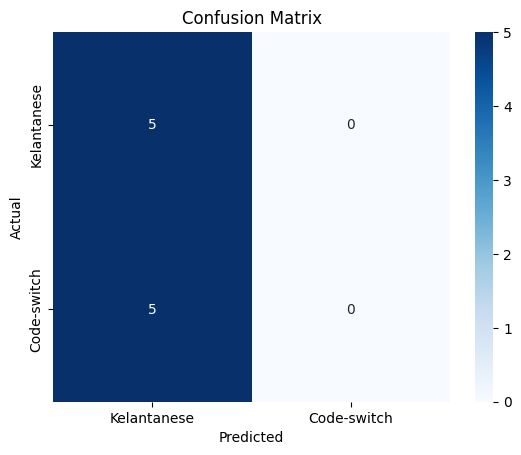

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert predictions and labels to numpy arrays
predictions_np = predictions.cpu().numpy()
labels_np = torch.tensor(labels).cpu().numpy()

# Generate and print classification report
report = classification_report(labels_np, predictions_np, target_names=['Kelantanese', 'Code-switch'])
print("Classification Report:\n", report)

# Generate confusion matrix
cm = confusion_matrix(labels_np, predictions_np)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Kelantanese', 'Code-switch'], yticklabels=['Kelantanese', 'Code-switch'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
